# Multilayer percepteron from scratch


Let's start by importing some libraries.

In [ ]:
#Libraries  to be installed:
!pip install pandas
!pip install numpy
!pip install matplotlib

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-0.745407,-1.147060,2.0
1,0.506179,-0.538141,0.0
2,-0.158551,-1.037025,2.0
3,-1.209638,-0.574745,1.0
4,0.457662,-0.398118,0.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

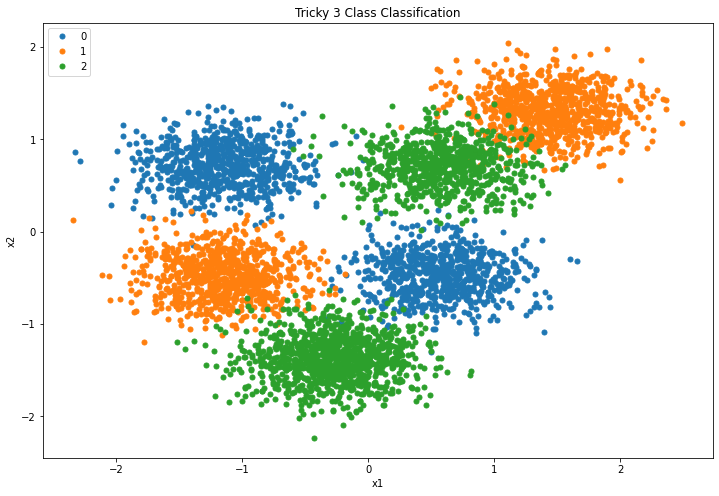

In [5]:
plot_data(X, y)

## Creating MLP

In [6]:
#Class for hidden layer
class Hidden:
    #Initializing class by taking input and output dimensions for each layer
    def __init__(self, dim_input, dim_output):
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.weight = np.random.uniform(size = (dim_input, dim_output))
        self.bias = np.random.uniform(size = (1, dim_output))
        
    def Relu(self, x):
        return np.maximum(x, np.zeros(x.shape))
    
    def Der_relu(self, x):
        return (x > 0) * 1
    
    #Forward propogation for hidden layer(s)
    def forward(self, X):
        self.hidden_without_relu = np.dot(X, self.weight) + self.bias
        
        #Passing through Relu activation
        self.hidden = self.Relu(self.hidden_without_relu)
        return self.hidden
    
    #Backprop for hidden layer(s)
    def backprop(self, dLdh, regularization, lr, hidden_layer, prev_hidden_layer):
        #Finding derivative of Relu of hidden layer
        der_relu = self.Der_relu(hidden_layer)
        term1 = np.multiply(der_relu, dLdh)
        
        #Graident of weight and bias for hidden layer(s)
        gradient_weight = np.dot(prev_hidden_layer.T, term1)
        gradient_bias = np.mean(term1, axis = 0).reshape(1, self.dim_output)
        
        #Computing next dLdh that will be passed onto previous hidden layer/input layer
        dLdx = np.dot(term1, self.weight.T)
        
        #Updating weights and bias based on graident and learning rate
        self.weight-= lr * gradient_weight
        self.bias-= lr * gradient_bias
        
        return dLdx
        
#Class for Output layer
class Output:
    #Initializing class by taking input and output dimensions
    def __init__(self, dim_input, dim_output):
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.weight = np.random.uniform(size = (dim_input, dim_output))
        self.bias = np.random.uniform(size = (1, dim_output))
    
    #Forward propogation for output layer
    def forward(self, hidden):
        self.output = np.dot(hidden, self.weight) + self.bias
        #Modifying output layer in order to maintain numerical stability
        self.output = self.output - np.max(self.output, axis=1)[:,None]
        return self.output
    
    #Backprop for output layer
    def backprop(self, dLdz, regularization, lr, last_hidden_layer):
        #Graident of weight and bias for output layer
        gradient_weight = np.dot(last_hidden_layer.T, dLdz)
        gradient_bias = np.mean(dLdz, axis = 0).reshape(1, self.dim_output)
        
        #Computing dLdh for last hidden layer (before output layer)
        dLdh = np.dot(dLdz, self.weight.T)
        
        #Updating weights and bias based on graident and learning rate
        self.weight-= lr * gradient_weight
        self.bias-= lr * gradient_bias
        return dLdh

#Class for Loss layer
class Loss:
    #Initializing class by taking input and output dimensions
    def __init__(self, dim_input, dim_output):
        self.dim_input = dim_input
        self.dim_output = dim_output
        
    #Forward propogation for loss layer
    def forward(self, z, y):
        #Computing loss
        loss_matrix = -z + np.log(np.sum(np.exp(z), axis=1)).reshape(z.shape[0], 1)
        
        #Considering loss only where y value is the same
        loss = np.zeros((loss_matrix.shape[0],1))
        for i in range(loss_matrix.shape[0]):
            loss[i][0] = loss_matrix[i][int(y[i])]
            
        return np.mean(loss)
    
    #Backprop for hidden layer
    def backprop(self, z, y):
        #Computing second term in differential of loss wrt z
        differential_term2 = np.exp(z) / np.sum(np.exp(z),axis=1).reshape(z.shape[0], 1)
        
        #Considering -1 term only where y value is same
        differential_term1 = np.zeros(z.shape)
        for i in range(z.shape[0]):
            differential_term1[i][int(y[i])] = -1
        
        #Computing final loss gradient
        dLdz = differential_term1 + differential_term2
        return dLdz

In [7]:
class MLP:
    #Initializing hidden, output and loss layers
    def __init__(self):
        self.hidden_layer = []
        self.output_layer = None
        self.loss_layer = None
    
    #Function to add/initialize layers as needed by network
    def add_layer(self, layer_type, dim_input, dim_output):
        if layer_type == "Hidden":
            self.hidden_layer.append(Hidden(dim_input, dim_output))
        elif layer_type == "Output":
            self.output_layer = Output(dim_input, dim_output)
        else:
            self.loss_layer = Loss(dim_input, dim_output)
    
    #Forward propogation of MLP
    def forward(self, X, y):
        #Calling forward prop for hidden layer(s)
        hidden_layers = []
        for i in (self.hidden_layer):
            hidden = i.forward(X)
            X = hidden
            hidden_layers.append(hidden)
            
        #Calling forward prop for output layer    
        z = self.output_layer.forward(hidden)
        
        #Calling forward prop for loss layer to compute loss
        loss = self.loss_layer.forward(z, y)
        
        #Factoring in regularization with L2 norm in loss calculation
        regularization_term = 0
        for i in range(len(self.hidden_layer)):
            regularization_term+= np.linalg.norm(self.hidden_layer[i].weight)**2
        regularization_term+= np.linalg.norm(self.output_layer.weight)**2
        regularization_term = self.lambda_/2 * regularization_term
        
        #Final loss computation
        loss+= regularization_term
        
        return z, loss, hidden_layers
    
    #Backprop of MLP
    def backprop(self, X, y, z, hidden_layer):
        #Calling backprop of loss layer to compute dLdz
        dLdz = self.loss_layer.backprop(z, y)
        
        #Calling backprop of output layer to compute dLdh
        dLdh = self.output_layer.backprop(dLdz, self.lambda_, self.lr, hidden_layer[-1])
        
        #Calling backprop of hidden layer(s) to compute dLdx of prev hidden layer
        for i in range(len(hidden_layer)-1, 0, -1):
            dLdx = self.hidden_layer[i].backprop(dLdh, self.lambda_, self.lr, hidden_layer[i], hidden_layer[i-1])
            dLdh = dLdx
        #Calling backprop of first hidden layer to compute dLdx of input layer    
        dLdx = self.hidden_layer[0].backprop(dLdh, self.lambda_, self.lr, hidden_layer[0], X)
    
    #Training function
    def train(self, epoch, X, y, learning_rate, batch_size, regularization_term):  
        self.lr = learning_rate
        self.batch_size = batch_size
        self.lambda_ = regularization_term
        
        #Obtaining and shuffling dataset
        data = np.concatenate((X, y), axis=1)
        data = np.random.permutation(data)
        times_per_epoch = int(X.shape[0]/self.batch_size)
        
        loss = []
        
        for e in range(epoch):
            data = np.random.permutation(data)
            for i in range(times_per_epoch):
                #Training in batches
                X = data[i*self.batch_size:(i+1)*self.batch_size, 0:2]
                y = data[i*self.batch_size:(i+1)*self.batch_size, [2]]
                
                #Calling forward prop of MLP
                z, l, hidden_layers = self.forward(X, y)
                
                #Saving loss
                loss.append(l)
                
                #Calling backprop of MLP
                self.backprop(X, y, z, hidden_layers)
        return loss
    
    #Function to predict output
    def predict(self, data):
        for i in (self.hidden_layer):
            hidden = i.forward(data)
            data = hidden
        z = self.output_layer.forward(hidden)
        output = np.argmax(z)
        return output

In [8]:
#Function to plot decision regions along with points
def plot_decision_regions(NN, title):
    fig, ax = plt.subplots(figsize=(12,8))
    
    #Generating random data
    data = np.random.uniform(-3, 3, (50000, 2))
    
    #Finding prpedictions and storing 
    predictions = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        predictions[i] = NN.predict(data[i, :])
    
    #Creating dataframe of input and output
    Data = pd.DataFrame({'X_1':data[:, 0], 'X_2':data[:, 1], 'Label':predictions})

    #Splitting based on classes for plotting
    df_2 = Data.loc[Data['Label'] == 2]
    df_1 = Data.loc[Data['Label'] == 1]
    df_0 = Data.loc[Data['Label'] == 0]
    
    #Plotting decision regions
    plt.scatter(df_0['X_1'], df_0['X_2'], label = '0_region')
    plt.scatter(df_1['X_1'], df_1['X_2'], label = '1_region')
    plt.scatter(df_2['X_1'], df_2['X_2'], label = '2_region')
    plt.suptitle(title, fontsize=20)
    plt.legend(loc="upper left")

    #Using given code to plot data clusters
    indices_0 = [k for k in range(0, X.shape[0]) if y[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y[k] == 2]
    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', c='c', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', c='m', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', c='y', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()
    
#Function to plot loss across iterations
def plot_loss(Loss):
    plt.plot(Loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.suptitle('Loss curve over iterations', fontsize=20)
    plt.show()

## Plotting decision regions

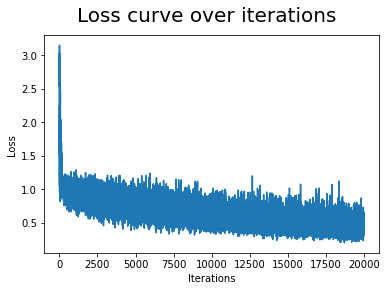

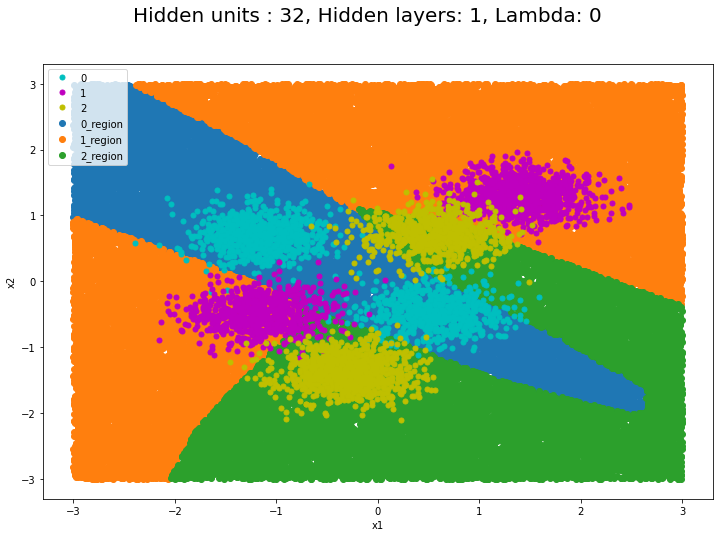

In [9]:
#Training sample: 1 hidden layer, 32 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 32)
NN.add_layer("Output", 32, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.0001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 32, Hidden layers: 1, Lambda: 0')

## c) Plots by varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and 0.09)

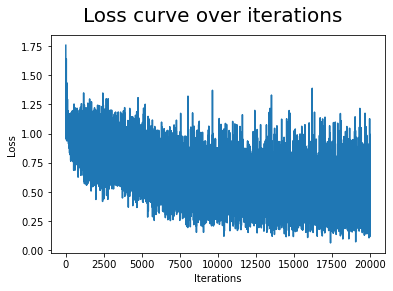

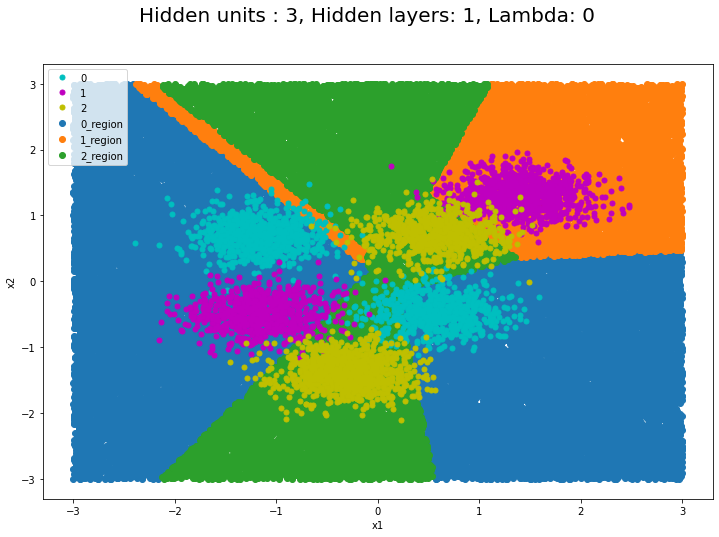

In [10]:
#Training 1: 1 hidden layer, 3 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 3)
NN.add_layer("Output", 3, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 3, Hidden layers: 1, Lambda: 0')

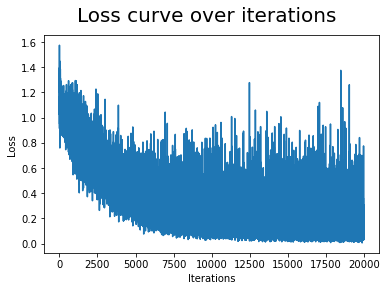

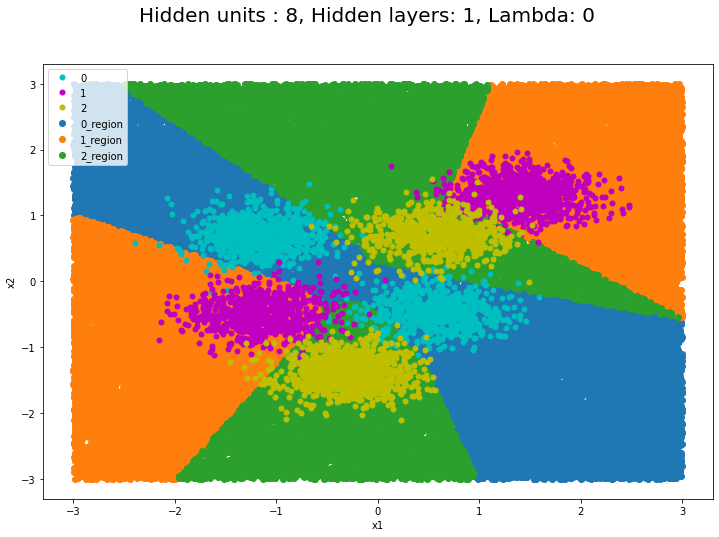

In [11]:
#Training 2: 1 hidden layer, 8 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 8, Hidden layers: 1, Lambda: 0')

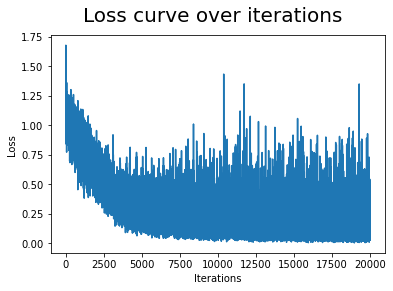

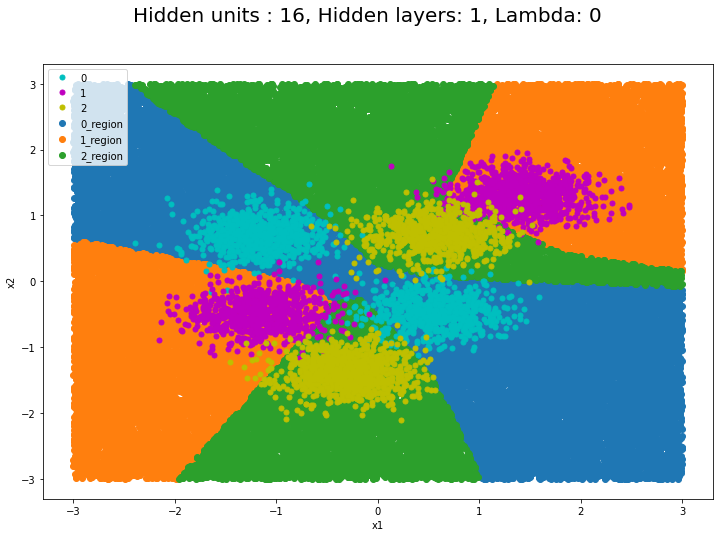

In [12]:
#Training 3: 1 hidden layer, 16 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 16, Hidden layers: 1, Lambda: 0')

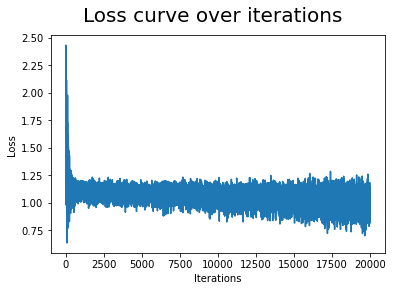

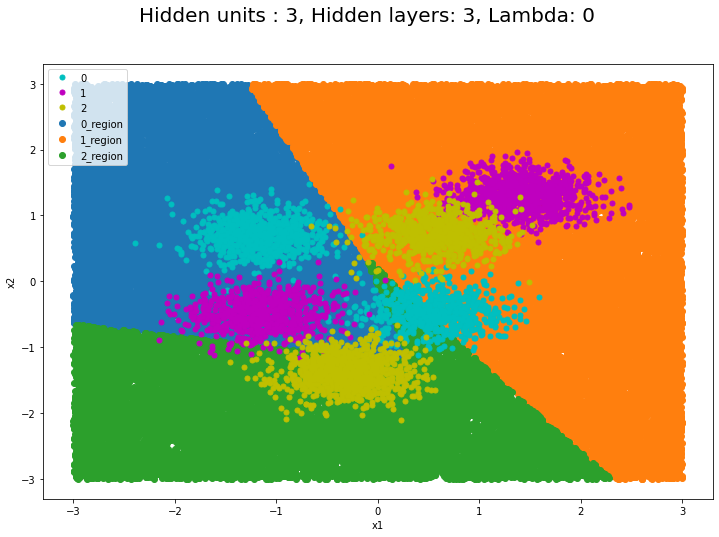

In [13]:
#Training 4: 3 hidden layers, 3 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 3)
NN.add_layer("Hidden", 3, 3)
NN.add_layer("Hidden", 3, 3)
NN.add_layer("Output", 3, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.0001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 3, Hidden layers: 3, Lambda: 0')

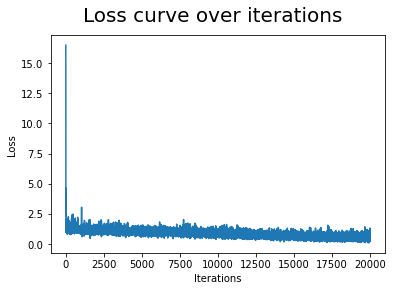

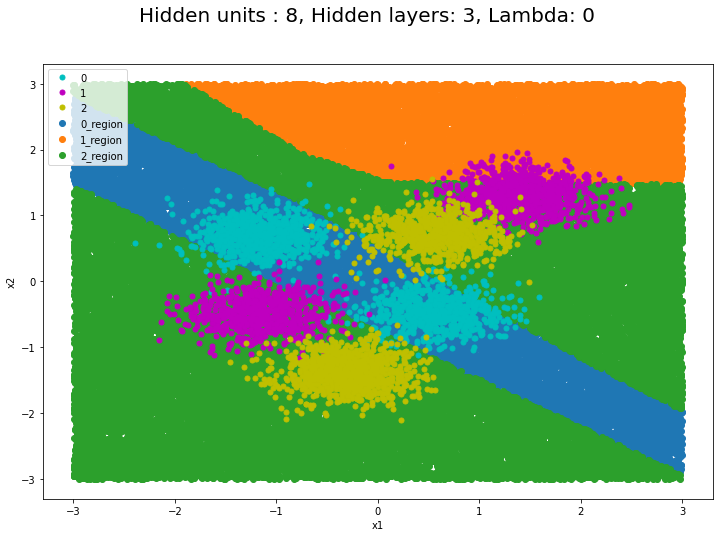

In [14]:
#Training 5: 3 hidden layers, 8 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.0001
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 8, Hidden layers: 3, Lambda: 0')

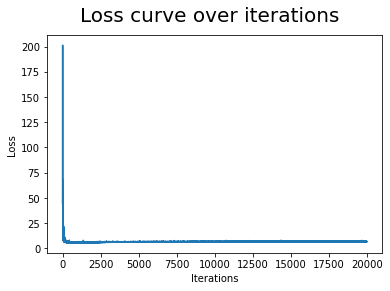

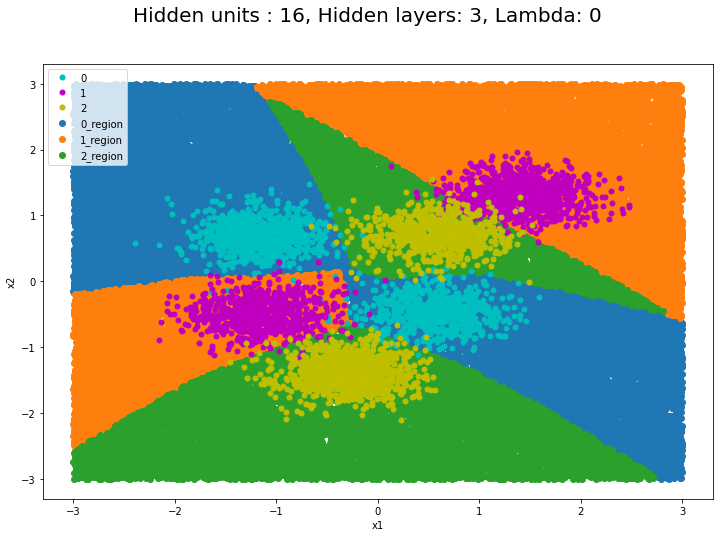

In [15]:
#Training 6: 3 hidden layers, 16 hidden units, no regularization
NN = MLP()
NN.add_layer("Hidden", 2, 16)
NN.add_layer("Hidden", 16, 16)
NN.add_layer("Hidden", 16, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.1

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 16, Hidden layers: 3, Lambda: 0')

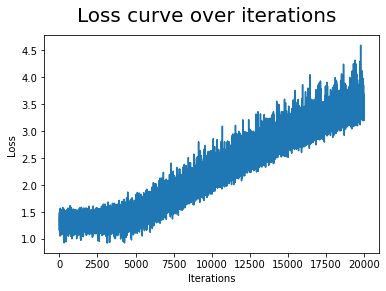

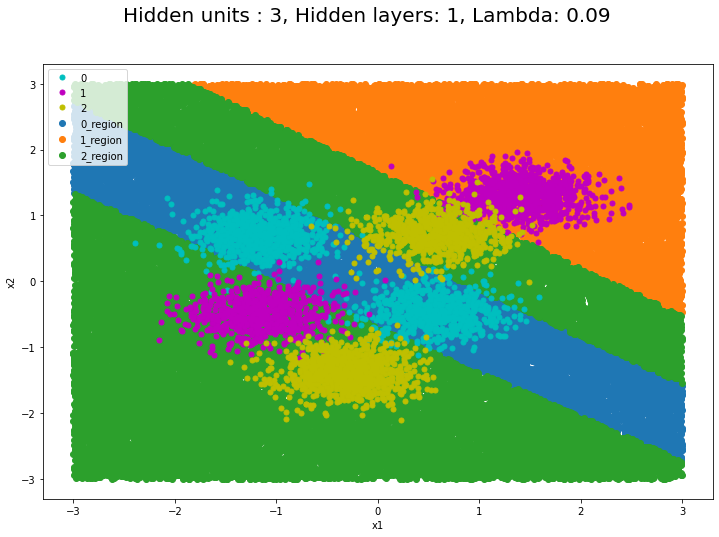

In [16]:
#Training 7: 1 hidden layer, 3 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 3)
NN.add_layer("Output", 3, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 3, Hidden layers: 1, Lambda: 0.09')

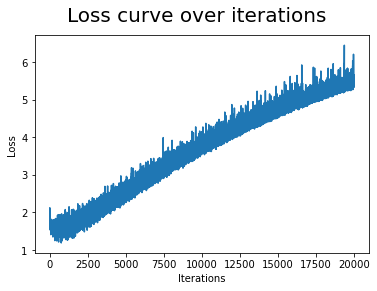

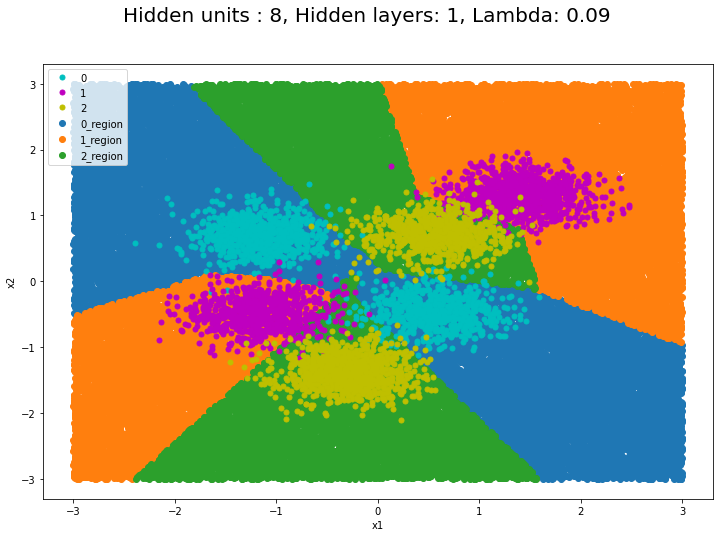

In [17]:
#Training 8: 1 hidden layer, 8 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 8, Hidden layers: 1, Lambda: 0.09')

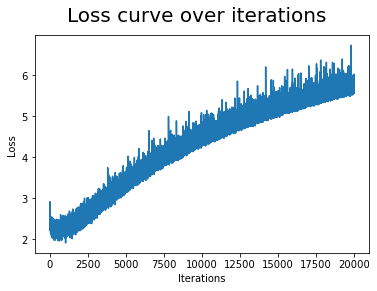

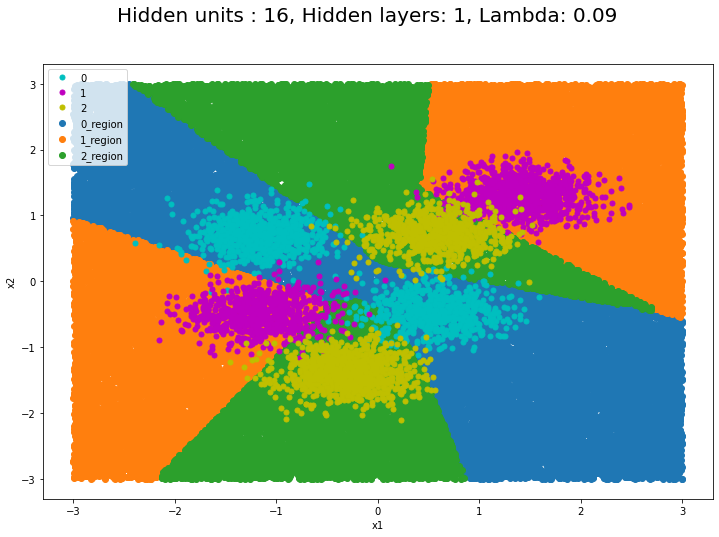

In [18]:
#Training 9: 1 hidden layer, 16 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 16, Hidden layers: 1, Lambda: 0.09')

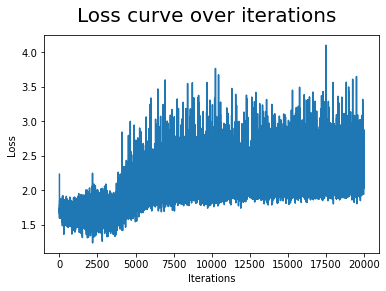

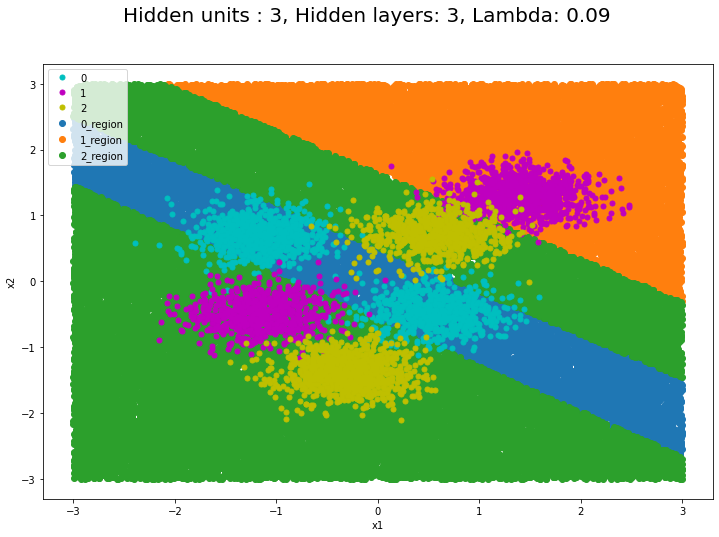

In [19]:
#Training 10: 3 hidden layers, 3 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 3)
NN.add_layer("Hidden", 3, 3)
NN.add_layer("Hidden", 3, 3)
NN.add_layer("Output", 3, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 3, Hidden layers: 3, Lambda: 0.09')

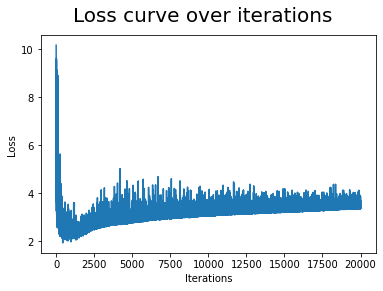

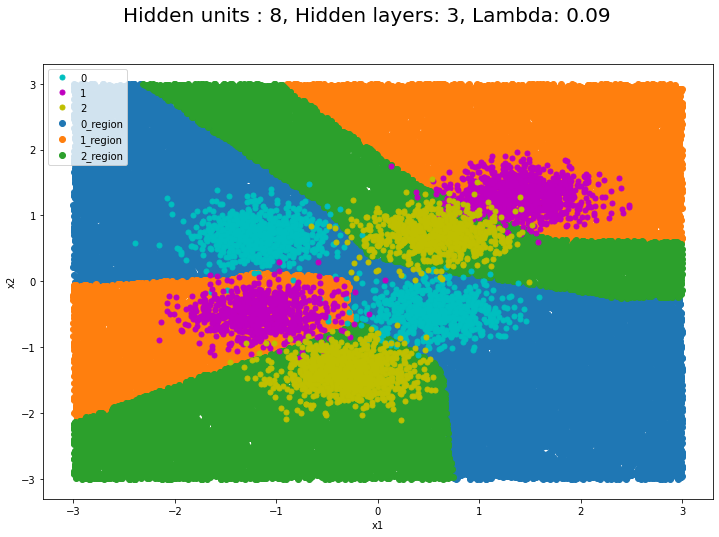

In [20]:
#Training 11: 3 hidden layers, 8 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 8, Hidden layers: 3, Lambda: 0.09')

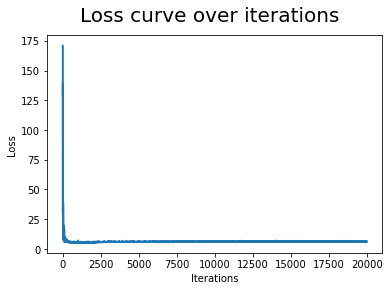

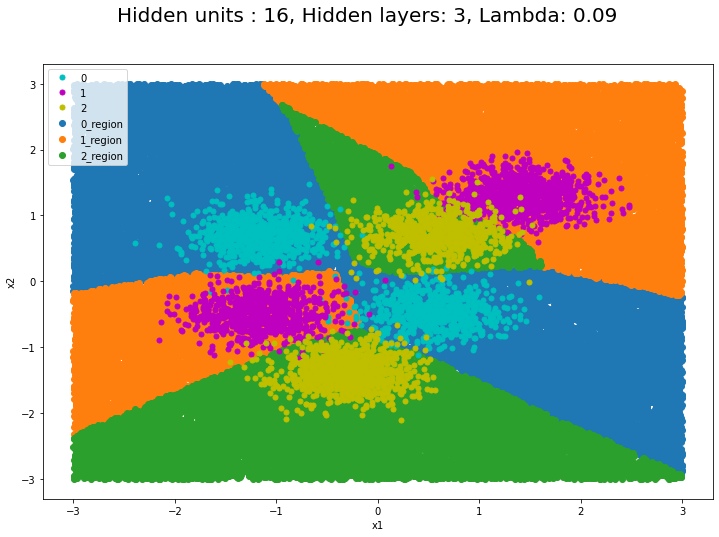

In [21]:
#Training 12: 3 hidden layers, 16 hidden units, 0.09 regularization
NN = MLP()
NN.add_layer("Hidden", 2, 16)
NN.add_layer("Hidden", 16, 16)
NN.add_layer("Hidden", 16, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.001
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X, y, learning_rate, batch_size, regularization_term)

#Plotting loss curve and decision regions
plot_loss(loss)
plot_decision_regions(NN, 'Hidden units : 16, Hidden layers: 3, Lambda: 0.09')

Overall, it can be observed that when there are 16 hidden units, the network performs best (with/without lambda). However, it performs very well with 8 hidden units (with just one layer as) and since this is computationally less expensive, we can choose that as a good balance. Regularization helps in few cases above to prevent overfitting

## Reusing MLP on data of choosing: 4 dimensional iris-flower dataset with 3 class classification

## Dataset is given below

Dataset - https://drive.google.com/file/d/1s09ftOj0G3radhj76r-69qdx0SGzi265/view?usp=sharing

In [7]:
#Accuracy function
def accuracy(X_val, y_val):
    accuracy = 0
    for i in range(X_val.shape[0]):
        if NN.predict(X_val[i]) == y_val[i]:
            accuracy+=1
    return(accuracy/X_val.shape[0])

#Function to plot loss across iterations
def plot_loss_new(Loss, title):
    plt.plot(Loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.suptitle(title, fontsize=20)
    plt.show()
    
class MLP_new:
    #Initializing hidden, output and loss layers
    def __init__(self):
        self.hidden_layer = []
        self.output_layer = None
        self.loss_layer = None
    
    #Function to add/initialize layers as needed by network
    def add_layer(self, layer_type, dim_input, dim_output):
        if layer_type == "Hidden":
            self.hidden_layer.append(Hidden(dim_input, dim_output))
        elif layer_type == "Output":
            self.output_layer = Output(dim_input, dim_output)
        else:
            self.loss_layer = Loss(dim_input, dim_output)
    
    #Forward propogation of MLP
    def forward(self, X, y):
        #Calling forward prop for hidden layer(s)
        hidden_layers = []
        for i in (self.hidden_layer):
            hidden = i.forward(X)
            X = hidden
            hidden_layers.append(hidden)
            
        #Calling forward prop for output layer    
        z = self.output_layer.forward(hidden)
        
        #Calling forward prop for loss layer to compute loss
        loss = self.loss_layer.forward(z, y)
        
        #Factoring in regularization with L2 norm in loss calculation
        regularization_term = 0
        for i in range(len(self.hidden_layer)):
            regularization_term+= np.linalg.norm(self.hidden_layer[i].weight)**2
        regularization_term+= np.linalg.norm(self.output_layer.weight)**2
        regularization_term = self.lambda_/2 * regularization_term
        
        #Final loss computation
        loss+= regularization_term
        
        return z, loss, hidden_layers
    
    #Backprop of MLP
    def backprop(self, X, y, z, hidden_layer):
        #Calling backprop of loss layer to compute dLdz
        dLdz = self.loss_layer.backprop(z, y)
        
        #Calling backprop of output layer to compute dLdh
        dLdh = self.output_layer.backprop(dLdz, self.lambda_, self.lr, hidden_layer[-1])
        
        #Calling backprop of hidden layer(s) to compute dLdx of prev hidden layer
        for i in range(len(hidden_layer)-1, 0, -1):
            dLdx = self.hidden_layer[i].backprop(dLdh, self.lambda_, self.lr, hidden_layer[i], hidden_layer[i-1])
            dLdh = dLdx
        #Calling backprop of first hidden layer to compute dLdx of input layer    
        dLdx = self.hidden_layer[0].backprop(dLdh, self.lambda_, self.lr, hidden_layer[0], X)
    
    #Training function
    def train(self, epoch, X, y, learning_rate, batch_size, regularization_term, X_test, y_test):  
        self.lr = learning_rate
        self.batch_size = batch_size
        self.lambda_ = regularization_term
        
        #Obtaining and shuffling dataset
        data = np.concatenate((X, y), axis=1)
        data = np.random.permutation(data)
        times_per_epoch = int(X.shape[0]/self.batch_size)
        
        loss = []
        prev_accuracy = 0
        current_accuracy = 10
        for e in range(epoch):
            data = np.random.permutation(data)
            for i in range(times_per_epoch):
                #Training in batches
                X = data[i*self.batch_size:(i+1)*self.batch_size, 0:4]
                y = data[i*self.batch_size:(i+1)*self.batch_size, [4]]
                
                #Calling forward prop of MLP
                z, l, hidden_layers = self.forward(X, y)
                
                #Saving loss
                loss.append(l)
                
                #Calling backprop of MLP
                self.backprop(X, y, z, hidden_layers)
            #Stopping training based on accuracy on test dataset
            current_accuracy = accuracy(X_test, y_test)
            if prev_accuracy - current_accuracy > 0 and e >= epoch/2:
                break
        return loss
    
    #Function to predict output
    def predict(self, data):
        for i in (self.hidden_layer):
            hidden = i.forward(data)
            data = hidden
        z = self.output_layer.forward(hidden)
        output = np.argmax(z)
        return output

In [8]:
#Reading iris flower csv into dataframe
df = pd.read_csv("C:/Users/aishw/OneDrive/Desktop/Fall21/DL for CV/HW3/iris.csv",names=["x1", "x2", "x3", "x4", "label"])

In [9]:
df.head()

,x1,x2,x3,x4,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
#Dataset praparation
cols = df.shape[1]
#Changing flower names to integer labels
df.loc[df['label'] == 'Iris-setosa', 'label'] = 0
df.loc[df['label'] == 'Iris-versicolor', 'label'] = 1
df.loc[df['label'] == 'Iris-virginica', 'label'] = 2
df = df.sample(frac=1).reset_index(drop=True)

#Splitting dataset into train, test and validation sets
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

#Train dataset separation
X_train = train.iloc[:,0:cols-1].to_numpy()
y_train = train.iloc[:,cols-1:cols].to_numpy().astype(float)

#Test dataset separation
X_test = test.iloc[:,0:cols-1].to_numpy()
y_test = test.iloc[:,cols-1:cols].to_numpy().astype(float)

#Validation dataset separation
X_val = validate.iloc[:,0:cols-1].to_numpy()
y_val = validate.iloc[:,cols-1:cols].to_numpy().astype(float)

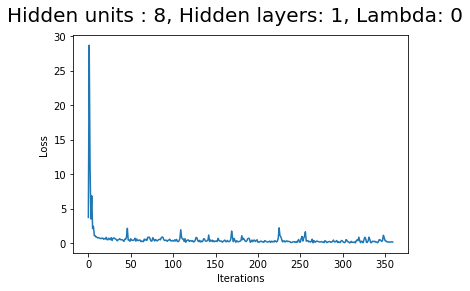

The accuracy on validation set is:  0.8333333333333334


In [13]:
#Training 1: 1 hidden layer, 8 hidden units, 0 regularization
NN = MLP_new()
NN.add_layer("Hidden", 4, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.01
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X_train, y_train, learning_rate, batch_size, regularization_term, X_test, y_test)

plot_loss_new(loss, 'Hidden units : 8, Hidden layers: 1, Lambda: 0')

print("The accuracy on validation set is: ", accuracy(X_val, y_val))

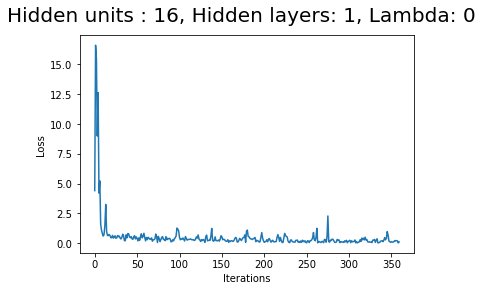

The accuracy on validation set is:  0.9666666666666667


In [14]:
#Training 2: 1 hidden layer, 16 hidden units, 0 regularization
NN = MLP_new()
NN.add_layer("Hidden", 4, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.01
batch_size = 10
epochs = 40
regularization_term = 0

#Training
loss = NN.train(epochs, X_train, y_train, learning_rate, batch_size, regularization_term, X_test, y_test)

plot_loss_new(loss, 'Hidden units : 16, Hidden layers: 1, Lambda: 0')

print("The accuracy on validation set is: ", accuracy(X_val, y_val))

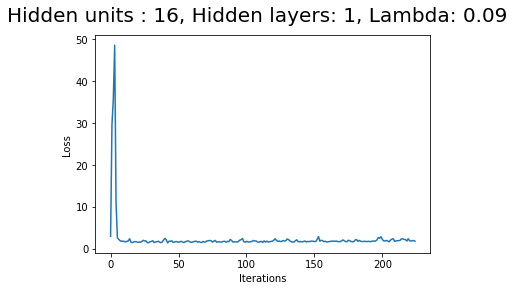

The accuracy on validation set is:  0.9666666666666667


In [41]:
#Training 3: 1 hidden layer, 16 hidden units, 0.09 regularization
NN = MLP_new()
NN.add_layer("Hidden", 4, 16)
NN.add_layer("Output", 16, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.01
batch_size = 10
epochs = 40
regularization_term = 0.09

#Training
loss = NN.train(epochs, X_train, y_train, learning_rate, batch_size, regularization_term, X_test, y_test)

plot_loss_new(loss, 'Hidden units : 16, Hidden layers: 1, Lambda: 0.09')

print("The accuracy on validation set is: ", accuracy(X_val, y_val))

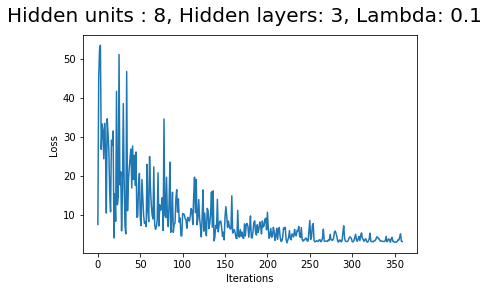

The accuracy on validation set is:  0.6666666666666666


In [42]:
#Training 4: 3 hidden layers, 8 hidden units, 0.1 regularization
NN = MLP_new()
NN.add_layer("Hidden", 4, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Hidden", 8, 8)
NN.add_layer("Output", 8, 3)
NN.add_layer("Loss", 3, 3)

#Specifying training parameters
learning_rate = 0.0001
batch_size = 10
epochs = 40
regularization_term = 0.1

#Training
loss = NN.train(epochs, X_train, y_train, learning_rate, batch_size, regularization_term, X_test, y_test)

plot_loss_new(loss, 'Hidden units : 8, Hidden layers: 3, Lambda: 0.1')

print("The accuracy on validation set is: ", accuracy(X_val, y_val))

It can be observed that the best performance of the MLP on the iris dataset is with 1 hidden laer of 16 hidden units with no regularization